In [1]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from datetime import datetime, timedelta
from typing import Tuple, Dict
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# 주피터 노트북 매직 커맨드
%matplotlib inline

# 한글 폰트 설정 (OS에 맞게 자동 설정)
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

In [3]:
# 환경 변수 로드
load_dotenv()
print("라이브러리 로드 및 시각화 설정 완료")

라이브러리 로드 및 시각화 설정 완료


In [4]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """SMAPE 계산"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    mask = denominator != 0
    if not np.any(mask):
        return 0.0
    smape_val = 200 * np.mean(np.abs(y_pred[mask] - y_true[mask]) / denominator[mask])
    return smape_val

In [5]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """결측치 / 타입 이상 처리"""
    df = df.copy()
    if "매출수량" in df.columns:
        df["매출수량"] = pd.to_numeric(df["매출수량"], errors="coerce").fillna(0).astype(int)
    for col in ["영업장명_메뉴명"]:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown").astype(str)
    return df

In [6]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """날짜 파생 변수 생성"""
    df = df.copy()
    df["요일"] = df["영업일자"].dt.weekday
    df["주차"] = df["영업일자"].dt.isocalendar().week.astype(int)
    df["월"] = df["영업일자"].dt.month
    
    def season(month: int) -> int:
        if month in (12, 1, 2): return 0
        if month in (3, 4, 5): return 1
        if month in (6, 7, 8): return 2
        return 3
    
    df["계절"] = df["월"].apply(season)
    df["is_weekend"] = df["요일"].isin([5, 6]).astype(int)

    month_period = pd.cut(
        df["영업일자"].dt.day,
        bins=[0, 10, 20, 31],
        labels=[1, 2, 3]
    )
    df["month_period"] = month_period.cat.codes.add(1).astype(int)

    df["is_before_weekend"] = (df["요일"] == 4).astype(int)
    df["is_after_weekend"] = (df["요일"] == 0).astype(int)

    return df

In [7]:
def add_menu_features(df: pd.DataFrame) -> pd.DataFrame:
    """메뉴명 분리 및 파생 변수"""
    df = df.copy()
    if "영업장명_메뉴명" not in df.columns:
        return df
    
    place_col, menu_col = [], []
    for v in df["영업장명_메뉴명"].astype(str):
        if "_" in v:
            p, m = v.split("_", 1)
        else:
            p, m = v, ""
        place_col.append(p)
        menu_col.append(m)
        
    df["영업장명"] = place_col
    df["메뉴명"] = menu_col
    df["is_group"] = df["영업장명_메뉴명"].str.contains("단체", na=False).astype(int)
    df["is_dessert"] = df["영업장명_메뉴명"].str.contains("후식", na=False).astype(int)

    df["menu_len"] = df["메뉴명"].astype(str).str.len()
    df["menu_token_cnt"] = df["메뉴명"].astype(str).str.split().str.len()

    premium_keywords = ["스페셜", "프리미엄", "특선", "세트", "단체", "정식", "2인", "4인"]
    df["is_premium"] = df["메뉴명"].astype(str).str.contains("|".join(premium_keywords), na=False).astype(int)

    return df

In [8]:
# 이동 평균 피처 생성 함수
def add_rolling_features(df):
    df = df.sort_values(["영업장명_메뉴명", "영업일자"]).copy()
    
    # 그룹별로 계산 (메뉴가 섞이지 않도록 주의)
    # window=7 (7일 평균), min_periods=1 (데이터가 1개만 있어도 계산)
    df["rolling_7_mean"] = df.groupby("영업장명_메뉴명")["매출수량"].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    
    # window=30 (30일 평균)
    df["rolling_30_mean"] = df.groupby("영업장명_메뉴명")["매출수량"].transform(
        lambda x: x.rolling(window=30, min_periods=1).mean()
    )
    
    # 주의: 이동평균에는 '오늘' 데이터가 포함되면 안 됩니다 (Data Leakage).
    # 따라서 shift(1)을 해줘서 '어제까지의 7일 평균'으로 만들어야 합니다.
    df["rolling_7_mean"] = df.groupby("영업장명_메뉴명")["rolling_7_mean"].shift(1)
    df["rolling_30_mean"] = df.groupby("영업장명_메뉴명")["rolling_30_mean"].shift(1)
    
    # shift 때문에 생긴 딱 하루(첫날)의 결측치는 0이나 해당 메뉴 전체 평균으로 채움
    df["rolling_7_mean"] = df["rolling_7_mean"].fillna(0)
    df["rolling_30_mean"] = df["rolling_30_mean"].fillna(0)
    
    # 7일 평균과 30일 평균의 비율
    df["rolling_ratio"] = df["rolling_7_mean"] / (df["rolling_30_mean"] + 1e-5)
    
    return df

In [9]:
def add_avg_features(df):
    # Train 데이터 기준 메뉴별 평균 매출 계산
    menu_mean = df.groupby('영업장명_메뉴명')['매출수량'].mean()

    # Train에 매핑
    df['메뉴_인코딩'] = df['영업장명_메뉴명'].map(menu_mean)

    # Test에 매핑 (주의: Train에 없던 메뉴는 전체 평균이나 0으로 채움)
    global_mean = df['매출수량'].mean()
    df['메뉴_인코딩'] = df['영업장명_메뉴명'].map(menu_mean).fillna(global_mean)

    return df

In [10]:
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = clean_data(df)
    df = add_date_features(df)
    df = add_menu_features(df)
    df = add_rolling_features(df)
    df = add_avg_features(df)
    return df

In [11]:
# 데이터 경로 설정 (현재 경로 기준 혹은 절대 경로 입력)
base_dir = os.getenv("DATA_DIR", "./") 

# 데이터 로드
train_path = os.path.join(base_dir, "train", "train.csv")
test_dir = os.path.join(base_dir, "test")
sub_path = os.path.join(base_dir, "sample_submission.csv")

In [12]:
train = pd.read_csv(train_path)
train["영업일자"] = pd.to_datetime(train["영업일자"])

test_files = {}
if os.path.isdir(test_dir):
    for fname in sorted(os.listdir(test_dir)):
        if fname.lower().endswith(".csv"):
            fpath = os.path.join(test_dir, fname)
            df = pd.read_csv(fpath)
            df["영업일자"] = pd.to_datetime(df["영업일자"])
            test_files[fname] = df

sample_submission = pd.read_csv(sub_path)

In [13]:
print(f"Train Shape: {train.shape}")
print(f"Test Files Count: {len(test_files)}")
display(train.head())

Train Shape: (102676, 3)
Test Files Count: 10


,영업일자,영업장명_메뉴명,매출수량
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0


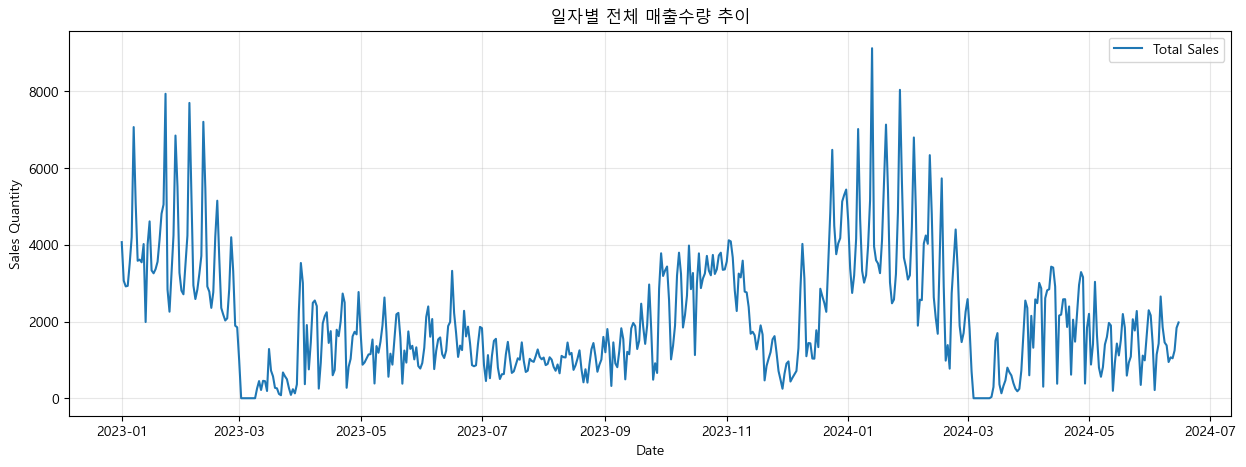

In [14]:
# 1. 전체 일자별 총 매출수량 추세
daily_sales = train.groupby("영업일자")["매출수량"].sum()

plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values, label='Total Sales')
plt.title("일자별 전체 매출수량 추이")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

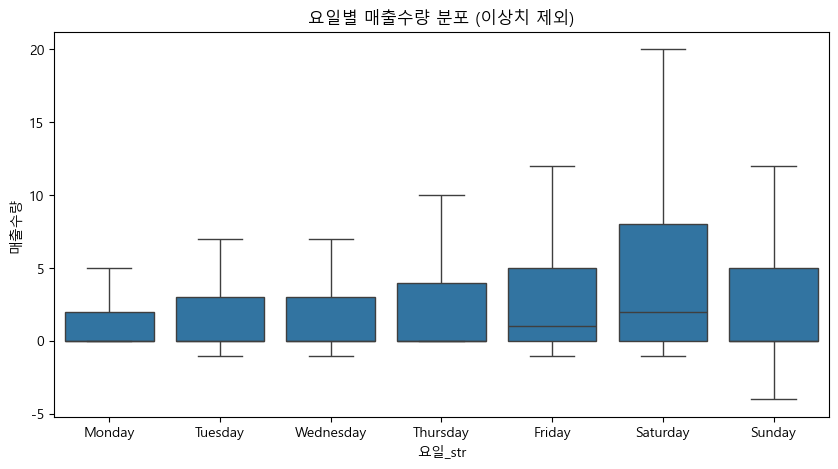

In [15]:
# 2. 요일별 매출 분포 (Boxplot)
train["요일_str"] = train["영업일자"].dt.day_name()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 5))
sns.boxplot(x="요일_str", y="매출수량", data=train, order=order, showfliers=False) # 이상치 제외하고 보기
plt.title("요일별 매출수량 분포 (이상치 제외)")
plt.show()

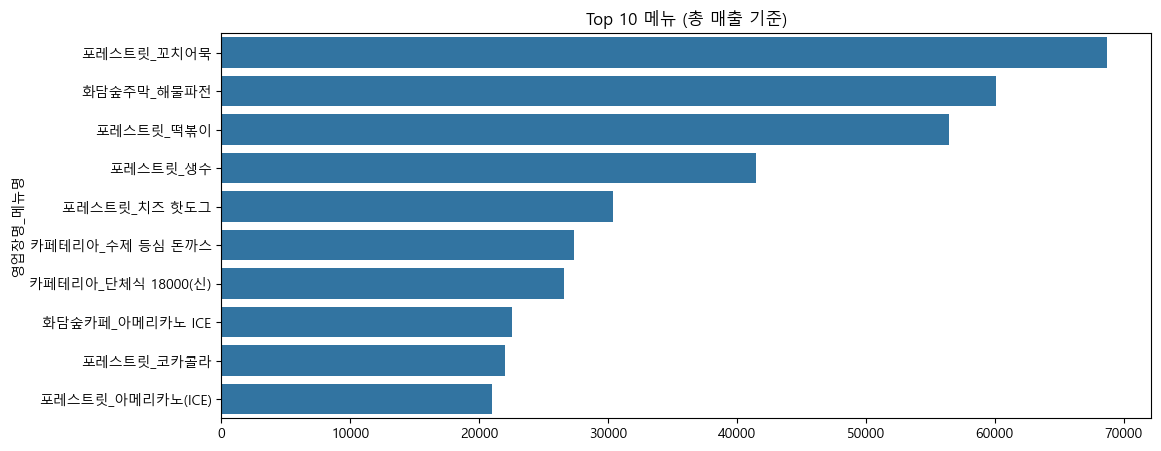

In [16]:
# 3. 상위 10개 인기 메뉴
top_menus = train.groupby("영업장명_메뉴명")["매출수량"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_menus.values, y=top_menus.index)
plt.title("Top 10 메뉴 (총 매출 기준)")
plt.show()

In [17]:
print("특성 공학 수행 중...")
train_fe = build_features(train)

특성 공학 수행 중...


In [18]:
# Test 데이터도 합쳐서 전처리
test_list = []
for name, df in test_files.items():
    df_copy = df.copy()
    df_copy["test_file"] = name
    test_list.append(df_copy)

In [19]:
test_result = []
for index, item in enumerate(test_list):
    new_item = build_features(item)
    test_list[index] = new_item


In [20]:
# 인코딩할 컬럼
cat_cols = ["영업장명_메뉴명", "영업장명", "메뉴명"]
cat_cols = [c for c in cat_cols if c in train_fe.columns]

In [21]:
# Label Encoding
train_enc = train_fe.copy()
encoders = {}

In [22]:
# Label Encoding (Train 기준으로만 fit; Test의 신규 카테고리는 Unknown 처리)

train_enc = train_fe.copy()

test_enc_list = [df.copy() for df in test_list]
encoders = {}

for col in cat_cols:
    train_vals = train_fe[col].astype(str).fillna("Unknown")

    classes = pd.Index(train_vals.unique())
    if "Unknown" not in classes:
        classes = classes.append(pd.Index(["Unknown"]))

    class_to_int = {c: i for i, c in enumerate(classes)}

    train_enc[col] = train_vals.map(class_to_int).astype(int)

    for i in range(len(test_enc_list)):
        test_vals = test_list[i][col].astype(str).fillna("Unknown")
        test_enc_list[i][col] = test_vals.map(lambda x: class_to_int.get(x, class_to_int["Unknown"]))

    encoders[col] = class_to_int

print("Label encoding 완료 (train-only)")


Label encoding 완료 (train-only)


In [23]:
# 위 셀에서 test_enc_list 를 생성했으므로 별도 처리 불필요
# (기존 셀은 test_fe 미정의 및 transform 대상 오류가 있어 교체)
pass


In [24]:
# Train / Valid Split (시간 순서 유지)
def prepare_train_valid(train_df, valid_ratio=0.1):
    train_sorted = train_df.sort_values("영업일자").reset_index(drop=True)
    n = len(train_sorted)
    split_idx = int(n * (1 - valid_ratio))
    return train_sorted.iloc[:split_idx], train_sorted.iloc[split_idx:]

train_df, valid_df = prepare_train_valid(train_enc)
print(f"Train set: {train_df.shape}, Valid set: {valid_df.shape}")

Train set: (92408, 23), Valid set: (10268, 23)


In [25]:
# train_fe_drop = train_fe.drop(labels=['매출수량'], axis=1)
# train_fe_drop.corr()

In [26]:
feature_cols = [
    "요일", 
    "월", "계절", "is_weekend",
    "영업장명_메뉴명", "메뉴명",
    "is_group", "is_dessert", "rolling_7_mean", "rolling_30_mean", "메뉴_인코딩",
    "month_period", "is_before_weekend", "is_after_weekend", "menu_len", "menu_token_cnt",
    "is_premium", "rolling_ratio",
    "주차", "영업장명", 
]

In [27]:
train_df[feature_cols + ["매출수량"]].corr()

,요일,월,계절,is_weekend,영업장명_메뉴명,메뉴명,is_group,is_dessert,rolling_7_mean,rolling_30_mean,...,month_period,is_before_weekend,is_after_weekend,menu_len,menu_token_cnt,is_premium,rolling_ratio,주차,영업장명,매출수량
요일,1.000000,1.609249e-02,2.295945e-03,0.791529,0.000022,0.000018,-0.000070,-0.000053,-0.001914,-0.002193,...,-0.000766,2.035753e-01,-6.132222e-01,0.000052,-0.000004,-1.662686e-06,-0.001098,7.691291e-03,0.000029,0.053284
월,0.016092,1.000000e+00,6.652644e-01,0.010830,0.000010,0.000008,-0.000031,-0.000023,-0.055595,-0.075837,...,0.015870,6.625048e-03,-1.120470e-02,0.000023,-0.000002,-7.320674e-07,0.122487,9.856667e-01,0.000013,-0.038193
계절,0.002296,6.652644e-01,1.000000e+00,-0.002028,0.000005,0.000004,-0.000017,-0.000013,-0.073471,-0.078193,...,0.010080,2.127166e-03,-4.724425e-03,0.000012,-0.000001,-3.950005e-07,0.052933,6.522717e-01,0.000007,-0.065212
is_weekend,0.791529,1.082968e-02,-2.028293e-03,1.000000,0.000014,0.000012,-0.000044,-0.000034,-0.001593,0.000136,...,0.001948,-2.575822e-01,-2.597857e-01,0.000033,-0.000003,-1.057160e-06,-0.005208,7.198303e-03,0.000019,0.049665
영업장명_메뉴명,0.000022,9.707786e-06,5.238015e-06,0.000014,1.000000,0.925326,-0.251636,-0.144373,0.220518,0.236751,...,-0.000027,9.008956e-06,9.086022e-06,-0.077815,-0.223565,-3.292908e-01,-0.015252,7.647510e-06,0.975021,0.188792
메뉴명,0.000018,7.984072e-06,4.307954e-06,0.000012,0.925326,1.000000,-0.237373,-0.137018,0.210442,0.227449,...,-0.000022,7.409326e-06,7.472708e-06,0.006595,-0.148985,-3.056472e-01,-0.010135,6.289618e-06,0.884553,0.179828
is_group,-0.000070,-3.079254e-05,-1.661469e-05,-0.000044,-0.251636,-0.237373,1.000000,-0.033781,0.056515,0.054621,...,0.000086,-2.857589e-05,-2.882034e-05,0.223273,0.147528,6.967546e-01,0.023885,-2.425747e-05,-0.194341,0.050143
is_dessert,-0.000053,-2.324528e-05,-1.254242e-05,-0.000034,-0.144373,-0.137018,-0.033781,1.000000,-0.030048,-0.032037,...,0.000065,-2.157193e-05,-2.175647e-05,0.008851,0.013461,-4.848343e-02,-0.004253,-1.831195e-05,-0.113511,-0.025799
rolling_7_mean,-0.001914,-5.559537e-02,-7.347073e-02,-0.001593,0.220518,0.210442,0.056515,-0.030048,1.000000,0.913730,...,-0.005022,9.554613e-06,1.163886e-03,-0.083946,-0.089701,1.184666e-02,0.161550,-5.681857e-02,0.246993,0.813368
rolling_30_mean,-0.002193,-7.583723e-02,-7.819300e-02,0.000136,0.236751,0.227449,0.054621,-0.032037,0.913730,1.000000,...,-0.004660,-1.547366e-03,3.910564e-03,-0.092377,-0.098141,7.825154e-03,0.045069,-7.716552e-02,0.262645,0.733065


<Axes: >

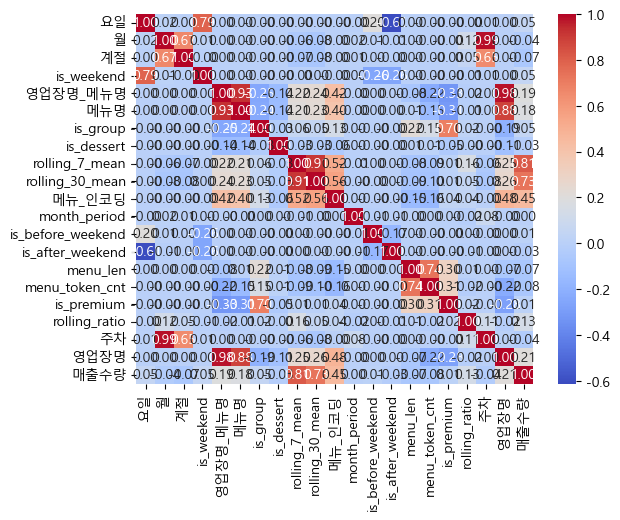

In [28]:
sns.heatmap(train_df[feature_cols + ["매출수량"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [29]:
feature_cols = [
    "요일", 
    "월", "계절",
    "영업장명_메뉴명", "메뉴명",
    "is_group", "rolling_7_mean", "rolling_30_mean", "메뉴_인코딩",
    "month_period", "is_before_weekend", "menu_len", "menu_token_cnt",
    "is_premium", "rolling_ratio",
    #"주차", "영업장명", "is_dessert", "is_weekend", "is_after_weekend",
]

In [30]:
model = xgboost.XGBRegressor(
    n_estimators=80,
    learning_rate=0.05,
    gamma=0,
    subsample=0.75,
    colsample_bytree=1,
    max_depth=10
)

In [31]:
print("모델 학습 시작...")
model.fit(train_df[feature_cols], train_df["매출수량"])

모델 학습 시작...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
# 검증
valid_pred = model.predict(valid_df[feature_cols])
y_true = valid_df["매출수량"].values

valid_pred_int = np.rint(valid_pred)
valid_pred_int = np.clip(valid_pred_int, 0, None)

smape_score = smape(y_true, valid_pred)
print(f"Validation SMAPE (raw): {smape_score:.4f}")

rmse = np.sqrt(mean_squared_error(y_true, valid_pred))
print(f"Validation RMSE (raw): {rmse:.4f}")

mae = mean_absolute_error(y_true, valid_pred)
print(f"Validation MAE (raw): {mae:.4f}")

smape_score_int = smape(y_true, valid_pred_int)
print(f"Validation SMAPE (int): {smape_score_int:.4f}")

rmse_int = np.sqrt(mean_squared_error(y_true, valid_pred_int))
print(f"Validation RMSE (int): {rmse_int:.4f}")

mae_int = mean_absolute_error(y_true, valid_pred_int)
print(f"Validation MAE (int): {mae_int:.4f}")


Validation SMAPE (raw): 127.2981
Validation RMSE (raw): 16.9055
Validation MAE (raw): 5.8449
Validation SMAPE (int): 120.6371
Validation RMSE (int): 16.9085
Validation MAE (int): 5.8444


In [33]:
# 테스트 (인코딩된 test_enc_list 사용)
test_score = {'smape':[], 'rmse':[], 'mae':[], 'smape_int':[], 'rmse_int':[], 'mae_int':[]}
for index, item in enumerate(test_enc_list):
    test_pred = model.predict(item[feature_cols])
    y_true = item["매출수량"].values

    test_pred_int = np.rint(test_pred)
    test_pred_int = np.clip(test_pred_int, 0, None)

    smape_score = smape(y_true, test_pred)
    test_score['smape'].append(smape_score)

    rmse = np.sqrt(mean_squared_error(y_true, test_pred))
    test_score['rmse'].append(rmse)

    mae = mean_absolute_error(y_true, test_pred)
    test_score['mae'].append(mae)

    smape_score_int = smape(y_true, test_pred_int)
    test_score['smape_int'].append(smape_score_int)

    rmse_int = np.sqrt(mean_squared_error(y_true, test_pred_int))
    test_score['rmse_int'].append(rmse_int)

    mae_int = mean_absolute_error(y_true, test_pred_int)
    test_score['mae_int'].append(mae_int)

test_score_df = pd.DataFrame(test_score)
print(test_score_df)

        smape       rmse       mae   smape_int   rmse_int   mae_int
0  136.401140  18.235085  5.191344  123.784805  18.241451  5.182457
1  120.269881  11.618428  3.676100  106.959879  11.624881  3.652295
2  136.765468  18.450528  6.207443  125.140035  18.453590  6.193375
3  116.899765  25.409790  8.614952  106.101797  25.406855  8.597521
4  123.184710  26.870841  7.857157  111.487418  26.873239  7.831236
5  123.112328  21.634382  6.951291  107.394921  21.636002  6.918579
6  115.464302  29.688629  9.471582  103.237057  29.687220  9.452442
7  150.731229  16.131698  4.474673  135.425437  16.137530  4.433568
8  139.483820  20.348926  5.636259  122.058784  20.354441  5.602332
9  134.322154  18.940693  6.115159  122.960254  18.944331  6.097890


In [34]:
print(test_score_df.mean())

smape        129.663480
rmse          20.732900
mae            6.419596
smape_int    116.455039
rmse_int      20.735954
mae_int        6.396169
dtype: float64


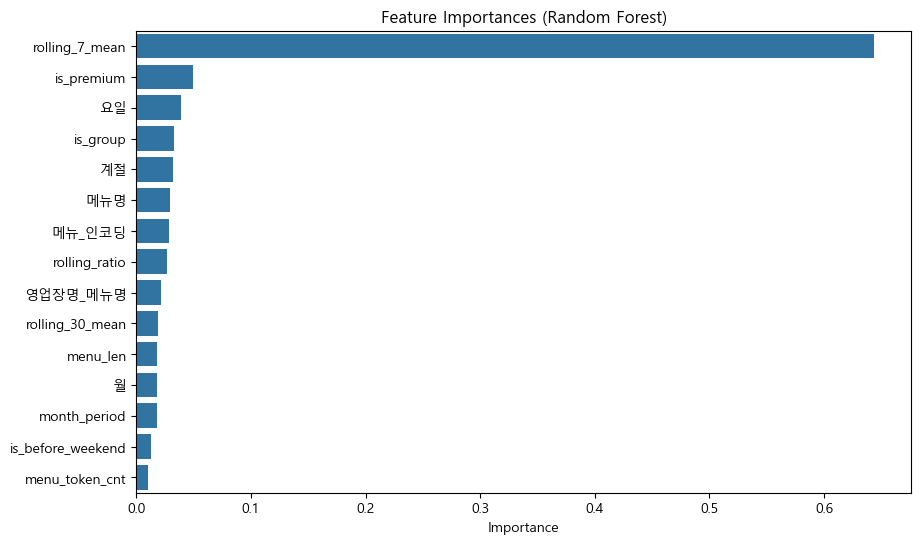

In [35]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_cols)[indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [36]:
valid_df.head()

,영업일자,영업장명_메뉴명,매출수량,요일_str,요일,주차,월,계절,is_weekend,month_period,...,메뉴명,is_group,is_dessert,menu_len,menu_token_cnt,is_premium,rolling_7_mean,rolling_30_mean,rolling_ratio,메뉴_인코딩
92408,2024-04-23,97,0,Tuesday,1,17,4,1,0,3,...,92,0,0,12,1,0,0.285714,0.466667,0.612232,0.609023
92409,2024-04-23,51,1,Tuesday,1,17,4,1,0,3,...,51,0,0,5,1,0,0.142857,0.566667,0.252096,1.090226
92410,2024-04-23,136,0,Tuesday,1,17,4,1,0,3,...,129,0,0,8,2,0,0.571429,0.700000,0.816315,1.417293
92411,2024-04-23,83,0,Tuesday,1,17,4,1,0,3,...,56,0,0,2,1,0,1.142857,0.966667,1.182254,1.001880
92412,2024-04-23,3,0,Tuesday,1,17,4,1,0,3,...,3,0,0,11,2,0,2.857143,4.333333,0.659339,2.755639


In [37]:
def build_series_for_forecast(train, test_files):
    dfs = [train]
    for df in test_files.values():
        dfs.append(df[["영업일자", "영업장명_메뉴명", "매출수량"]])
    all_df = pd.concat(dfs, axis=0, ignore_index=True)
    all_df["영업일자"] = pd.to_datetime(all_df["영업일자"])
    all_df = all_df.sort_values(["영업장명_메뉴명", "영업일자"]).reset_index(drop=True)
    return all_df

In [38]:
def naive_menu_level_forecast(all_df, horizon=7):
    forecasts = {}
    for menu, g in all_df.groupby("영업장명_메뉴명"):
        g_sorted = g.sort_values("영업일자")
        last_vals = g_sorted["매출수량"].tail(7).values
        mean_val = float(np.mean(last_vals)) if len(last_vals) > 0 else 0.0
        forecasts[menu] = np.array([mean_val] * horizon)
    return forecasts

In [39]:
def fill_submission_with_forecast(sample_submission, forecasts, horizon=7):
    sub = sample_submission.copy()
    menu_cols = [c for c in sub.columns if c != "영업일자"]
    n_rows = len(sub)
    repeats = int(np.ceil(n_rows / horizon))

    for col in menu_cols:
        menu_name = col
        pattern = forecasts[col] if col in forecasts else np.zeros(horizon, dtype=float)
        full_pred = np.tile(pattern, repeats)[:n_rows]
        sub[col] = full_pred
    return sub

In [40]:
# 실행
print("제출용 데이터 생성 중...")
all_series = build_series_for_forecast(train, test_files)
forecasts = naive_menu_level_forecast(all_series, horizon=7)
submission = fill_submission_with_forecast(sample_submission, forecasts, horizon=7)

제출용 데이터 생성 중...


In [41]:
output_path = os.path.join(base_dir, "submission.csv")

# 예측값은 float로 나올 수 있으므로 제출 포맷에 맞게 정수 변환
menu_cols = [c for c in submission.columns if c != "영업일자"]
submission[menu_cols] = submission[menu_cols].round().clip(lower=0).astype(int)

submission.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"저장 완료: {output_path}")
display(submission.head())


저장 완료: ./submission.csv


,영업일자,느티나무 셀프BBQ_1인 수저세트,느티나무 셀프BBQ_BBQ55(단체),"느티나무 셀프BBQ_대여료 30,000원","느티나무 셀프BBQ_대여료 60,000원","느티나무 셀프BBQ_대여료 90,000원","느티나무 셀프BBQ_본삼겹 (단품,실내)",느티나무 셀프BBQ_스프라이트 (단체),느티나무 셀프BBQ_신라면,느티나무 셀프BBQ_쌈야채세트,...,화담숲주막_스프라이트,화담숲주막_참살이 막걸리,화담숲주막_찹쌀식혜,화담숲주막_콜라,화담숲주막_해물파전,화담숲카페_메밀미숫가루,화담숲카페_아메리카노 HOT,화담숲카페_아메리카노 ICE,화담숲카페_카페라떼 ICE,화담숲카페_현미뻥스크림
0,TEST_00+1일,4,40,5,2,1,1,22,1,2,...,5,11,11,5,86,26,41,70,17,29
1,TEST_00+2일,4,40,5,2,1,1,22,1,2,...,5,11,11,5,86,26,41,70,17,29
2,TEST_00+3일,4,40,5,2,1,1,22,1,2,...,5,11,11,5,86,26,41,70,17,29
3,TEST_00+4일,4,40,5,2,1,1,22,1,2,...,5,11,11,5,86,26,41,70,17,29
4,TEST_00+5일,4,40,5,2,1,1,22,1,2,...,5,11,11,5,86,26,41,70,17,29
